# Mengimport library pandas untuk membaca file csv

In [1]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
import csv
import requests
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive




*   Membaca file csv yang sebelumnya sudah diunduh dari kode scrapping
*   Mengetahui jumlah kolom dan jumlah ulasan pada file df/csv




In [3]:
# Membaca file CSV dari Google Drive
app_reviews_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Proyek Analisis Sentimen/review_growtopia_mobile_app.csv", header=None, names=["Review"])

# Mendapatkan jumlah ulasan (baris) dan jumlah kolom
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape
print("Jumlah ulasan (baris):", jumlah_ulasan)
print("Jumlah kolom:", jumlah_kolom)

Jumlah ulasan (baris): 110000
Jumlah kolom: 1


# Menampilkan info dataframe

In [4]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  110000 non-null  object
dtypes: object(1)
memory usage: 859.5+ KB


# Melakukan pembersihan: menghapus nilai yang kosong/null values

In [6]:
growtopia_df = app_reviews_df.dropna().drop_duplicates()
growtopia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  9999 non-null   object
dtypes: object(1)
memory usage: 156.2+ KB


#### Melihat info df lagi, terdapat perubahan jumlah data pada df setelah dilakukan pembersihan

In [7]:
growtopia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  9999 non-null   object
dtypes: object(1)
memory usage: 156.2+ KB


### Pre-processing text: membuat beberapa fungsi untuk memfilter teks

In [9]:
# Fungsi preprocessing teks
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Hapus hashtag
    text = re.sub(r'RT[\s]', '', text)         # Hapus RT
    text = re.sub(r"http\S+", '', text)        # Hapus URL
    text = re.sub(r'[0-9]+', '', text)        # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)       # Hapus tanda baca
    text = text.replace('\n', ' ')            # Ganti newline dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

# Penanganan stopwords dengan pengecualian kata negasi
negation_words = {'tidak', 'bukan', 'belum', 'tanpa'}
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian')).union(set(stopwords.words('english')))
    listStopwords.update(['iya', 'yaa', 'ya', 'gak', 'ga', 'gaa', 'nya', 'na', 'sih', 'ku', 'di', 'loh', 'kah', 'kh', 'woi', 'woii', 'woy', 'wkwk'])
    return [txt for txt in text if txt not in listStopwords or txt in negation_words]

def toSentence(list_words):
    return ' '.join(list_words)

#### Tokenization: membuat kata baku atau pembenaran dari slangwords (bahasa gaul)

In [10]:
slangwords = {
    "@": "di", "abis": "habis", "masi": "masih", "bgt": "banget", "maks": "maksimal", "plisss": "tolong",
    "indo": "indonesia", "ad": "ada", "plis": "tolong", "pls": "tolong", "cod": "bayar di tempat",
    "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ak": "saya",
    "alay": "norak", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar",
    "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "ato": "atau",
    "au ah": "tidak mau tahu", "ay": "sayang", "ayank": "sayang", "bakalan": "akan", "bandes": "bantuan desa",
    "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan",
    "bentar": "sebentar", "beresin": "membereskan", "bete": "bosan", "bg": "abang", "bgmn": "bagaimana",
    "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh",
    "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "boker": "buang air besar",
    "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan",
    "bt": "buat", "btw": "ngomong-ngomong", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak",
    "cengengesan": "tertawa", "cepet": "cepat", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong",
    "cmpur": "campur", "cpe": "capek", "d": "di", "dah": "deh", "dapet": "dapat", "dek": "adik", "demen": "suka",
    "dgn": "dengan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan",
    "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "dongs": "dong", "dpt": "dapat",
    "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh",
    "emng": "memang", "endak": "tidak", "enggak": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa",
    "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa",
    "gebetan": "orang yang disuka", "geje": "tidak jelas", "gile": "gila", "gimana": "bagaimana", "gj": "tidak jelas",
    "gmana": "bagaimana", "goblok": "bodoh", "gpny": "tidak punya", "gtau": "tidak tahu", "gua": "saya",
    "guoblok": "goblok", "gw": "saya", "haha": "tertawa", "hlm": "halaman", "hny": "hanya", "hr": "hari",
    "hrus": "harus", "huff": "mengeluh", "ilang": "hilang", "iye": "iya", "ja": "saja", "jadiin": "jadi",
    "jdi": "jadi", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jutek": "galak",
    "k": "ke", "kab": "kabupaten", "kalo": "kalau", "kampret": "sialan", "kanwil": "kantor wilayah",
    "karna": "karena", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kel": "kelurahan",
    "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "ketrima": "diterima", "kl": "kalau",
    "klw": "kalau", "km": "kamu", "kmrn": "kemarin", "krm": "kirim", "ktmu": "ketemu", "ktr": "kantor",
    "kyk": "seperti", "la": "lah", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung",
    "liat": "lihat", "lp": "lupa", "org": "orang", "lum": "belum", "luthu": "lucu", "lwn": "lawan",
    "maacih": "terima kasih", "macem": "macam", "macih": "masih", "magabut": "makan gaji buta",
    "maksain": "memaksa", "mepet": "dekat sekali", "mgu": "minggu", "problem": "masalah", "tahi": "kotoran",
    "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "makasi": "terima kasih", "mnolak": "tolak",
    "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "benarjujur": "jujur", "mgkin": "mungkin",
    "app": "aplikasi", "sat set": "cepat", "bpj": "bpjs", "kls": "kelas", "gk": "tidak",
    "kelinik": "klinik", "nakes": "tenaga kesehatan"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

#### Mengecek nama kolom sebelum menjalankan fungsi

In [11]:
print(growtopia_df.columns)
growtopia_df.head()

Index(['Review'], dtype='object')


,Review
0,"Game ampas, sering error connection padahal si..."
1,Growtopia sekarang kok makin rusak ya setiap k...
2,Besarin servernya. Masa gw main sinyal lancar ...
3,Segi gameplay cocok untuk jadikan game kategor...
4,Saya tidak bilang game ini jelek tapi ada bebe...


#### Menjalankan fungsi-fungsi yang telah dibuat sebelumnya

In [12]:
growtopia_df['text_clean'] = growtopia_df['Review'].apply(cleaningText)
growtopia_df['text_casefoldingText'] = growtopia_df['text_clean'].apply(casefoldingText)
growtopia_df['text_slangwords'] = growtopia_df['text_casefoldingText'].apply(fix_slangwords)
growtopia_df['text_tokenizingText'] = growtopia_df['text_slangwords'].apply(tokenizingText)
growtopia_df['text_stopword'] = growtopia_df['text_tokenizingText'].apply(filteringText)
growtopia_df['text_akhir'] = growtopia_df['text_stopword'].apply(toSentence)

### Pelabelan: Mengimport kamus kata-kata positif dan negatif dari github

In [13]:
# Mengimport kamus lexicon
lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Fungsi analisis sentimen
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        score += lexicon_positive.get(word, 0) + lexicon_negative.get(word, 0)
    polarity = 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
    return score, polarity

# Pelabelan
results = growtopia_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
growtopia_df['polarity_score'], growtopia_df['polarity'] = zip(*results)
print(growtopia_df['polarity'].value_counts())

polarity
negative    6647
positive    2760
neutral      592
Name: count, dtype: int64


#### Pelabelan: Membuat fungsi untuk menentukan skor dalam kata positif, negatif, dan netral sesuai kamus yang sudah didapat

In [14]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]
    polarity = 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
    return score, polarity

#### Pelabelan: Hasil dari pelabelan

In [15]:
results = growtopia_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
growtopia_df['polarity_score'] = results[0]
growtopia_df['polarity'] = results[1]
print(growtopia_df['polarity'].value_counts())

polarity
negative    6647
positive    2760
neutral      592
Name: count, dtype: int64


### Data splitting dengan tf-idf

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=2000, min_df=3, max_df=0.8, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(growtopia_df['text_akhir'])
y = growtopia_df['polarity']

# Split data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### Pemodelan: Logistic Regression dengan RandomizedSearchCV

In [17]:
param_dist_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logistic_regression = LogisticRegression(max_iter=1000)
random_search_lr = RandomizedSearchCV(logistic_regression, param_dist_lr, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_lr.fit(X_train, y_train)

best_lr = random_search_lr.best_estimator_
y_pred_test_lr = best_lr.predict(X_test)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)
print('Best parameters:', random_search_lr.best_params_)

Logistic Regression - accuracy_test: 0.8615
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}


### Pemodelan: SVM dengan RandomizedSearchCV

In [18]:
param_dist_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1]
}

svm_model = SVC(probability=True)
random_search_svm = RandomizedSearchCV(svm_model, param_dist_svm, n_iter=15, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_svm.fit(X_train, y_train)

best_svm = random_search_svm.best_estimator_
y_pred_test_svm = best_svm.predict(X_test)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('Best parameters:', random_search_svm.best_params_)

SVM - accuracy_test: 0.844
Best parameters: {'kernel': 'linear', 'gamma': 'auto', 'C': 1}


### Pemodelan: Random Forest

In [19]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_test_rf = rf_model.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_test: 0.732


### Pemodelan: Voting Classifier

In [20]:
voting_clf = VotingClassifier(estimators=[
    ('lr', best_lr),
    ('svm', best_svm),
    ('rf', rf_model)
], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred_test_voting = voting_clf.predict(X_test)
accuracy_test_voting = accuracy_score(y_test, y_pred_test_voting)
print('Voting Classifier - accuracy_test:', accuracy_test_voting)

Voting Classifier - accuracy_test: 0.8615


### Melihat hasil akurasi semua model

In [21]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'Voting Classifier'],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_svm, accuracy_test_rf, accuracy_test_voting]
})
print("\nAkurasi Testing Set (Urut):")
print(results_df.sort_values(by='Accuracy Test', ascending=False))


Akurasi Testing Set (Urut):
                 Model  Accuracy Test
0  Logistic Regression         0.8615
3    Voting Classifier         0.8615
1                  SVM         0.8440
2        Random Forest         0.7320


### Memprediksi dengan model terbaik (Voting Classifier)

In [22]:
kalimat_baru = input("Masukkan kalimat baru: ")

kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

X_kalimat_baru = tfidf.transform([kalimat_baru_final]).toarray()
prediksi_sentimen = voting_clf.predict(X_kalimat_baru)

if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif prediksi_sentimen[0] == 'negative':
    print("Sentimen kalimat baru adalah NEGATIF.")
else:
    print("Sentimen kalimat baru adalah NETRAL.")

probabilities = voting_clf.predict_proba(X_kalimat_baru)
print("Probabilitas:", probabilities)

Masukkan kalimat baru: HI
Sentimen kalimat baru adalah NEGATIF.
Probabilitas: [[0.59257303 0.13974422 0.26768275]]


### Melakukan visualisasi analisis sentimen dari hasil pelabelan data

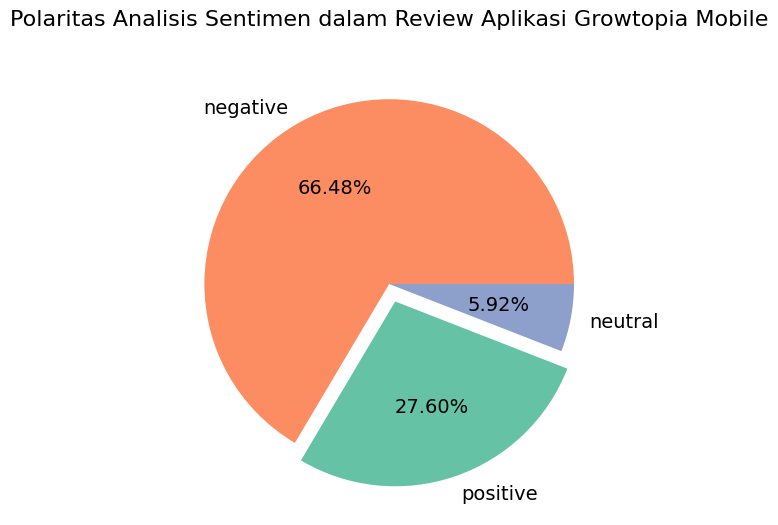

In [28]:
import matplotlib.pyplot as plt

sizes = [count for count in growtopia_df['polarity'].value_counts()]
labels = list(growtopia_df['polarity'].value_counts().index)
explode = [0.1 if label == 'positive' else 0 for label in labels]
colors = ['#FC8D62', '#66C2A5', '#8DA0CB']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(x=sizes, labels=labels, autopct='%1.2f%%', explode=explode, textprops={'fontsize': 14}, colors=colors)

ax.set_title('Polaritas Analisis Sentimen dalam Review Aplikasi Growtopia Mobile', fontsize=16, pad=20)
plt.show()

#### Membuat tweets positif, negatif, dan netral untuk visualisasi

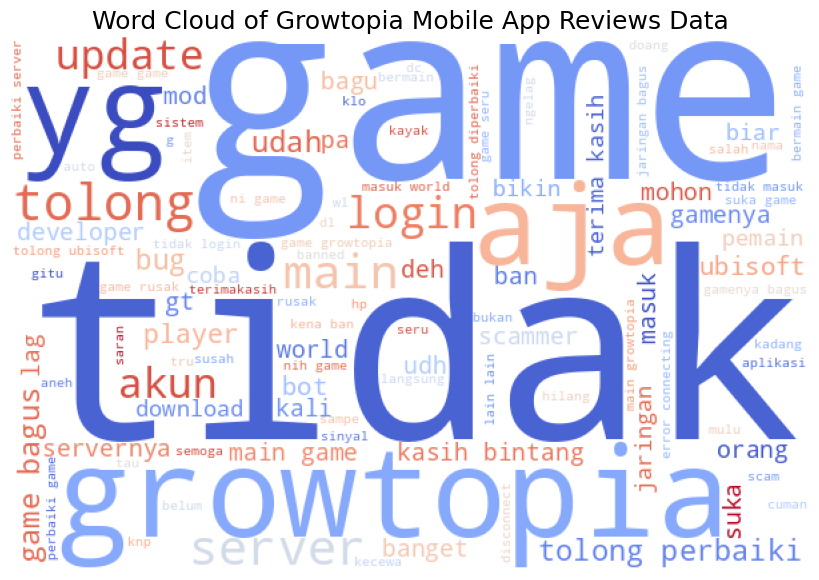

In [30]:
# Impor library yang diperlukan
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Atur opsi pandas
import pandas as pd
pd.set_option('display.max_colwidth', 3000)

# Filter tweet positif
positive_tweets = growtopia_df[growtopia_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

# Filter tweet negatif
negative_tweets = growtopia_df[growtopia_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)
negative_tweets = negative_tweets[0:10]
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

# Filter tweet netral
neutral_tweets = growtopia_df[growtopia_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=True)
neutral_tweets = neutral_tweets[0:10]
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

# Visualisasi: Wordcloud semua kata
list_words = ''
for tweet in growtopia_df['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10, colormap='coolwarm').generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Growtopia Mobile App Reviews Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()

#### Memvisulisasi: wordcloud kata negatif

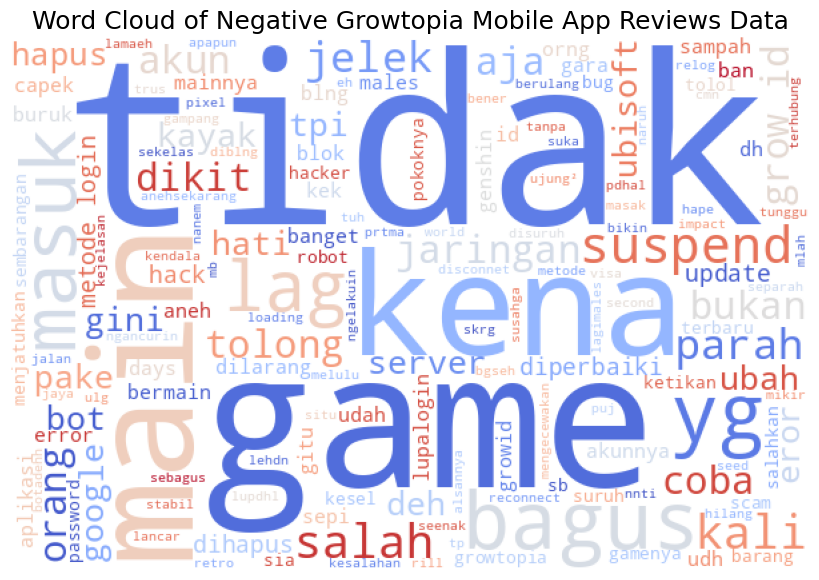

                                                                                                                                                                                                                                                                                                                                                                                            text_akhir  \
1                        tidak bikin tpi akun kena ban game skrg aneh anehsekarang jaringan sebagus apapun disconnet puj masuk world loading ujung² tidak visa masuk coba relog trus masuk ulg disuruh tunggu second coba tidak jaringan bagus game sepi jelek tpi jaringan yg bagus kek situ bagus aja game sepi genshin tuh tidak error game cmn pake mb tpi suka error melulu aneh dikit dikit eror   
2                                        parah parah parah parah separah parah server tidak stabil banget gampang lag dikit lag lag lag nanem seed tidak naruh blok tidak ngancurin blok tidak banget berulang kali 

In [31]:
list_words = ''
for tweet in negative_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10, colormap='coolwarm').generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Growtopia Mobile App Reviews Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()
print(negative_tweets[['text_akhir', 'polarity_score']])

In [32]:
print(negative_tweets[['text_akhir', 'polarity_score']])

                                                                                                                                                                                                                                                                                                                                                                                            text_akhir  \
1                        tidak bikin tpi akun kena ban game skrg aneh anehsekarang jaringan sebagus apapun disconnet puj masuk world loading ujung² tidak visa masuk coba relog trus masuk ulg disuruh tunggu second coba tidak jaringan bagus game sepi jelek tpi jaringan yg bagus kek situ bagus aja game sepi genshin tuh tidak error game cmn pake mb tpi suka error melulu aneh dikit dikit eror   
2                                        parah parah parah parah separah parah server tidak stabil banget gampang lag dikit lag lag lag nanem seed tidak naruh blok tidak ngancurin blok tidak banget berulang kali 

#### Memvisulisasi: wordcloud kata positif

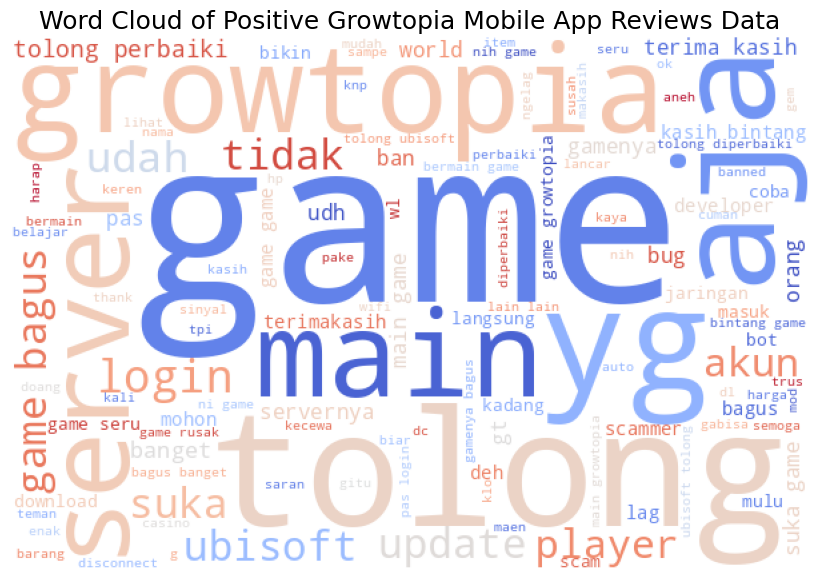

                                                                                                                                                                                                                                                                                                   text_akhir  \
1                                                                                                                                                           game terbaik belajar belum telanjang famousterkenal lahir telanjang dewasa baju celana kerja keras ubisoft thanks u game game friends thank ghont   
2     terimakasih growtopia mengajarkanku sabar game memberiku manfaat makasih udah bikin kesabaranku meningkat anak rajin berbakti orang tua game rekomendasi adick berkembang terimakasih growtopia terimakasih erconnya semoga erconnya parah yaaa kesabaran meningkat bersyukur server bagus makasih yaaa   
3                                                                                    

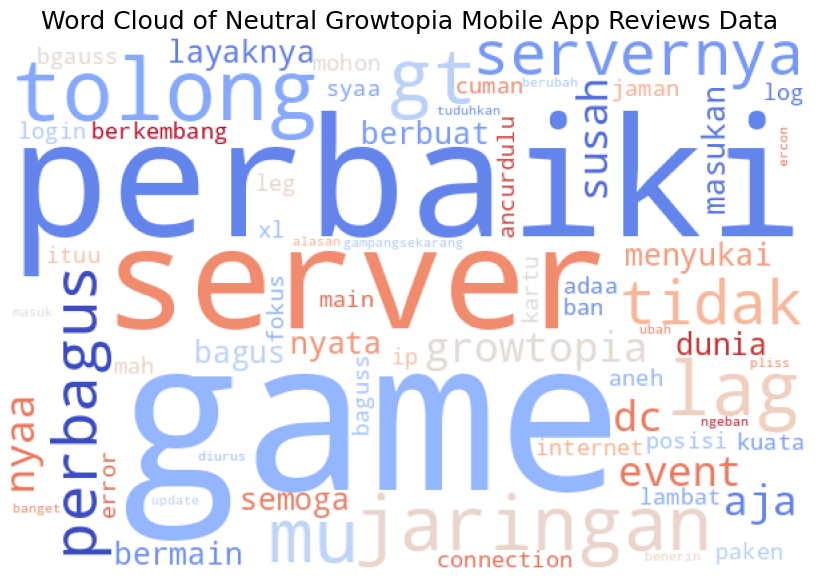

                                                                                                                                                              text_akhir  \
1   game bagus tolong perbaiki servernya tidak lag menyukai game game berbuat layaknya dunia nyata tolong servernya perbagus tidak lag bermain masukan semoga berkembang   
2                                                          mohon perbaiki internet kuata paken kartu xl cuman growtopia aja main dc tolong perbaiki syaa growtopia jaman   
3                                                                perbaiki game mu perbagus event log error connection ban ip aneh perbaiki game mu server mu fokus event   
4                                                                       game nyaa bgauss adaa server nyaa leg jaringan gt posisi ituu jaringan baguss jaringan gt lambat   
5                                                                     game ancurdulu mah login gampangsekarang susah banget masuk aja game s

In [33]:
list_words = ''
for tweet in positive_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10, colormap='coolwarm').generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Growtopia Mobile App Reviews Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()
print(positive_tweets[['text_akhir', 'polarity_score']])

# Visualisasi: Wordcloud kata netral
list_words = ''
for tweet in neutral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10, colormap='coolwarm').generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Growtopia Mobile App Reviews Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
ax.axis('off')
fig.tight_layout(pad=0)
plt.show()
print(neutral_tweets[['text_akhir', 'polarity_score']])

In [34]:
print(positive_tweets[['text_akhir', 'polarity_score']])

                                                                                                                                                                                                                                                                                                   text_akhir  \
1                                                                                                                                                           game terbaik belajar belum telanjang famousterkenal lahir telanjang dewasa baju celana kerja keras ubisoft thanks u game game friends thank ghont   
2     terimakasih growtopia mengajarkanku sabar game memberiku manfaat makasih udah bikin kesabaranku meningkat anak rajin berbakti orang tua game rekomendasi adick berkembang terimakasih growtopia terimakasih erconnya semoga erconnya parah yaaa kesabaran meningkat bersyukur server bagus makasih yaaa   
3                                                                                    

#### Memvisualisasi: Distribusi kelas kata, kata yang sering muncul, dan distribusi panjang teks

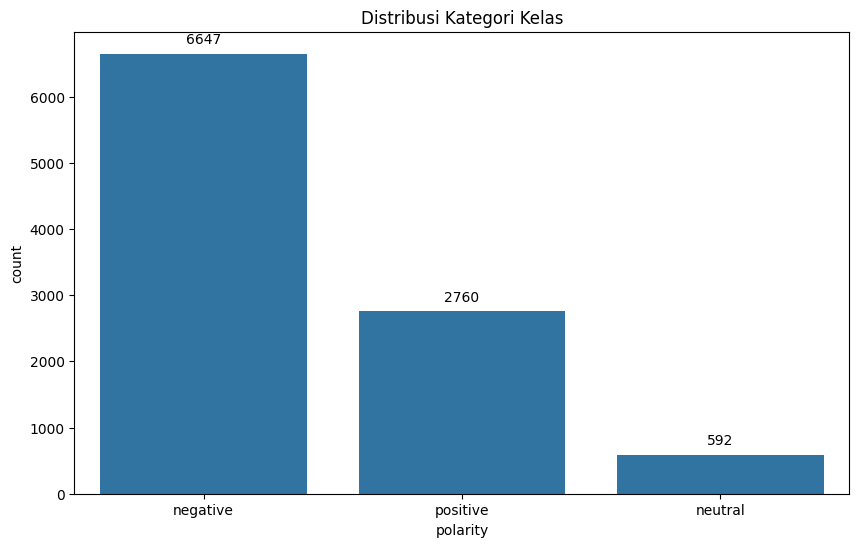

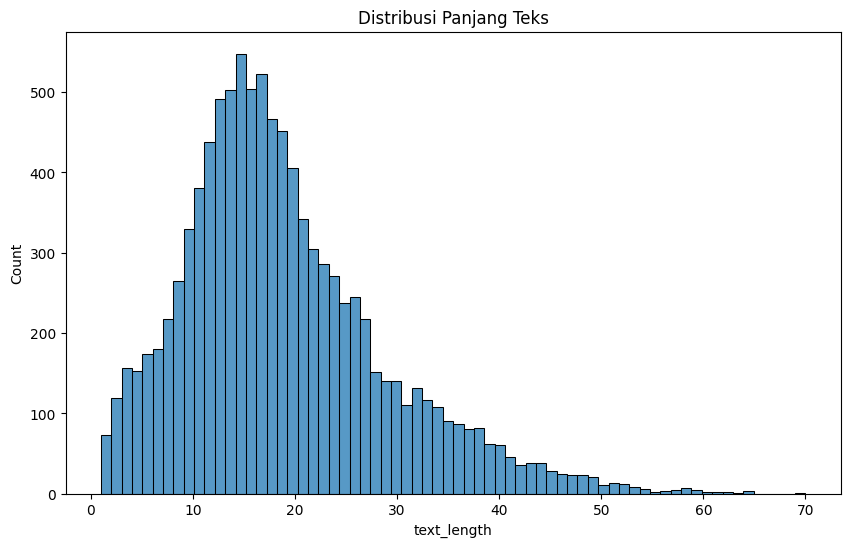

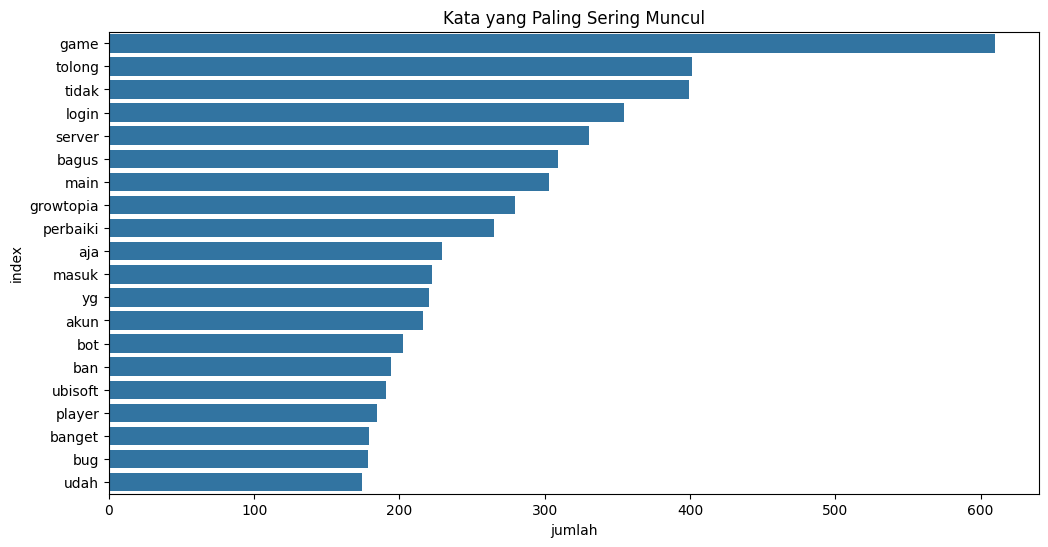

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
class_dist_plot = sns.countplot(x='polarity', data=growtopia_df)
plt.title('Distribusi Kategori Kelas')
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')
plt.show()

plt.figure(figsize=(10, 6))
growtopia_df['text_length'] = growtopia_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(growtopia_df['text_length'])
plt.title('Distribusi Panjang Teks')
plt.show()

plt.figure(figsize=(12, 6))
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(growtopia_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata yang Paling Sering Muncul')
plt.show()

### Menyimpan requirements.txt

In [36]:
import subprocess

installed_packages = subprocess.check_output(["pip", "freeze"]).decode("utf-8").split('\n')
desired_packages = {"Flask", "requests", "numpy", "pandas", "scikit-learn", "nltk", "Sastrawi", "matplotlib", "seaborn"}
filtered_packages = [pkg for pkg in installed_packages if pkg.split('==')[0] in desired_packages]

with open('requirements.txt', 'w') as f:
    for pkg in filtered_packages:
        f.write(pkg + '\n')